In [ ]:
!pip install praw pandas seaborn

In [5]:
import csv
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns

from utils import *

sns.set_theme()

In [6]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [2]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [2]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

# Searching for posts by keyword

This won't find comments with the keyword but whatever, could be useful for giving us an idea of which subreddits have which words

In [47]:
keyword_listings = search(
    reddit.subreddit("all"),
    " OR ".join(f"{keyword}~" for keyword in keywords),
)

In [59]:
with open("search-all-by-keyword.csv", "a") as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)

    i = 0
    for submission in keyword_listings:
        writer.writerow(comment_relevant_fields(submission))
        i += 1
        if i > 10:
            break

# Getting comments from a post

In [3]:
listing = reddit.subreddit("unix").search('*', params={ "after": "t3_18zyt6g", "restrict_sr": True })
submissions = list(listing)
submissions

Fetching: GET https://oauth.reddit.com/r/unix/search/ at 1706734256.1732607
Data: None
Params: {'after': 't3_18zyt6g',
 'limit': 100,
 'q': '*',
 'raw_json': 1,
 'restrict_sr': True,
 'sort': 'relevance',
 'syntax': 'lucene',
 't': 'all'}
Response: 200 (62399 bytes) (rst-177:rem-599.0:used-1 ratelimit) at 1706734258.9487572


[Submission(id='1865xk2'),
 Submission(id='18qw8g9'),
 Submission(id='12pol3l'),
 Submission(id='17nn015'),
 Submission(id='18m7ea8'),
 Submission(id='17rre4b'),
 Submission(id='181hlcv'),
 Submission(id='zxulj4'),
 Submission(id='17jgifc'),
 Submission(id='18argdy'),
 Submission(id='18k6tli'),
 Submission(id='17tsw5v'),
 Submission(id='110nkii'),
 Submission(id='18jhs81'),
 Submission(id='17w07g9'),
 Submission(id='11bs899'),
 Submission(id='17l0qif'),
 Submission(id='17e2r50'),
 Submission(id='189vzyq'),
 Submission(id='17u0tl6'),
 Submission(id='18bcwv3'),
 Submission(id='17l8aq6'),
 Submission(id='17mtz7p'),
 Submission(id='17jpid4'),
 Submission(id='180l0ea'),
 Submission(id='16fc9dt'),
 Submission(id='184l9kb'),
 Submission(id='17lmjmt'),
 Submission(id='xpb2l8'),
 Submission(id='1856q95'),
 Submission(id='17vas0t'),
 Submission(id='10g0742'),
 Submission(id='17y11qr'),
 Submission(id='17tiiw2'),
 Submission(id='1816txd'),
 Submission(id='15swuun'),
 Submission(id='11wnw56'),
 Su

In [8]:
[s.url for s in submissions]

['https://www.reddit.com/r/unix/comments/1865xk2/some_help_with_openssl_fileenc_from_machine_a_to/',
 'https://www.idatum.net/upgrading-from-netbsd-51-to-10_rc1.html',
 'https://www.reddit.com/r/unix/comments/12pol3l/searching_for_the_most_unusual_desktop_environment/',
 'https://www.reddit.com/r/unix/comments/17nn015/beginner_question_how_to_properly_implement_dup2/',
 'https://www.delhi-magazine.com/education/overview-of-unix-operating-system/',
 'https://www.reddit.com/r/unix/comments/17rre4b/mongoose_not_accepting_callback/',
 'https://www.reddit.com/r/unix/comments/181hlcv/new_to_mac/',
 'https://www.reddit.com/r/unix/comments/zxulj4/fyi_grexorg_dies_on_2023_apr_15/',
 'https://www.reddit.com/r/unix/comments/17jgifc/kali_linux_error/',
 'https://byte-sized.de/uncategorized/freebsd-streaming-mit-chromium-moeglich-dank-widevine-support/#english',
 'https://freebsdfoundation.org/blog/2024-freebsd-community-survey-is-here/',
 'https://i.redd.it/jmkzvzez7zzb1.png',
 'https://i.redd.it/

In [9]:
comments = submissions[0].comments.list()
comments

In [11]:
comments[0].body

'Bash vs zsh won’t make a difference, but Sonoma has LibreSSL 3, and Mojave…doesn’t. I’m not sure what version it does have, but OpenSSL 1.0.2 was contemporary with Mojave so it cant be anything newer. I know for sure there were some breaking changes between 1.0.x and 1.1.x, and more between 1.1.x and 3.0.x.\n\nYou need to remember that OpenSSL is a suite of encryption primitives. Presentation will make a huge difference. The `openssl` command is really only intended as a developer/debugging tool for prototyping the library and not really meant to for end user facing purposes.\n\nTry these:\n\n* `openssl enc -e -aes-256-cbc -salt -a`\n* `openssl enc -d -aes-256-cbc -salt -a`\n\nThe `-a` uses ascii encoding and that may get around the issue you’re having. If not, then you’re probably completely out of luck with using openssl in this case.'

# Sampling comments randomly (by ID)

Since IDs are sequential, we can just sample them. But this won't guarantee all the keywords we want will show up

In [4]:
random.seed(0)

In [5]:
# Run to restore state
with open("rand-state.txt", "r") as file:
    random.setstate(eval(file.readline())) # todo deserialize properly

In [8]:
first_id = int("1000000", 36)  # todo find the ID of the first post we want to analyze
last_id = int("k000000", 36)  # todo find the ID of the last post we want to analyze
with open("sample-all.csv", "a") as file, open("misses.txt", "a") as misses:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    while True:
        # IDs must be in lowercase base 36
        ids = [
            "t1_" + np.base_repr(random.randrange(first_id, last_id), 36).lower()
            for _ in range(100)
        ]
        # Ask for info on 100 IDs at once because PRAW makes batches of 100
        info = reddit.info(fullnames=ids)
        try:
            hits = []
            for submission in info:
                assert submission.name.startswith("t1")
                hits.append(submission.name)
                # Only keep undeleted comments
                if submission.body != "[removed]" and submission.body != "[deleted]":
                    writer.writerow(comment_relevant_fields(submission))
            misses.writelines(
                id.removeprefix("t1_") + "\n" for id in ids if id not in hits
            )
        except Exception as e:
            print(e, e.__class__, id)
            break

KeyboardInterrupt: 

In [9]:
# Run to save state to pick back up later
with open("rand-state.txt", "w") as file:
    file.write(str(random.getstate())) # todo serialize properly

## Load comments

In [7]:
from datetime import datetime

df = pd.read_csv("sample-all.csv", names=COMMENT_COLS)
df.drop_duplicates(inplace=True)
df["body"] = df["body"].map(str)
df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts).date())
df

,name,subreddit,time,body
0,ei5yh1p,Granblue_en,2019-03-09,Thank you! So it was working as intended. And ...
1,ftj6bfm,worldnews,2020-06-09,I am having a productive discussion by calling...
2,ikv838q,baseballcards,2022-08-18,I bought a box of NFL cards at a card show las...
3,c7ql4x6,gonewildcurvy,2013-01-03,How could I gorget that gorgeous body and that...
4,hps8193,dankmemes,2021-12-24,downvote this comment if the meme sucks. upvot...
...,...,...,...,...
50650,jogftzm,thickwhitegirls,2023-06-17,Just added you
50651,j6q59ku,BiggerThanYouThought,2023-01-31,Our subreddit has specific guidelines about th...
50652,jssxqfz,Antipsychiatry,2023-07-20,"Yep, they certainly can. I was diagnosed with ..."
50653,culh6jg,elderscrollsonline,2015-08-30,IC? What does that mean?


In [12]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [8]:
df["body"] = df["body"].map(lambda body: body.lower().strip())
matched_rows = df[df["body"].map(matches)]
matched_rows

,name,subreddit,time,body
21,fszn69a,Showerthoughts,2020-06-05,i think it’s actually the massive amounts of m...
54,ei0m7ng,Granblue_en,2019-03-07,"yeah, i actually really like how they didn't j..."
108,i1bmnrr,u/jesterboyd,2022-03-19,one of the problems is that people on the far-...
191,icu1wl8,Damnthatsinteresting,2022-06-18,yes new york is so beautiful so many homeless ...
330,g139g81,AmItheAsshole,2020-08-11,yta. shaming people for their weight doesn’t w...
...,...,...,...,...
50351,houl0tj,WaterCoolerWednesday,2021-12-16,raiders fans getting ptsd hearing nick mullens...
50509,f85mc24,Parenting,2019-11-20,as someone who works with abusers i understand...
50547,jlg1bns,AskMen,2023-05-24,no it is not. if your partner did hard drugs o...
50618,ge69kzz,AskReddit,2020-11-30,many of my friends have gotten addicted to che...


In [33]:
df[df["body"].map(lambda text: matches(text, keywords=["neurodiverge"]))]["body"]

21438    being perpetually confused by neurotypical hum...
48970    that's my experience at the moment. i have adh...
Name: body, dtype: object

In [30]:
{
    keyword: len(matched_rows[matched_rows["body"].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 46,
 'gaslight': 10,
 'trigger': 90,
 'toxic': 63,
 'woke': 37,
 'manipulat': 54,
 'microaggression': 0,
 'autis': 22,
 'adhd': 22,
 'ocd': 11,
 'ptsd': 16,
 'bipolar': 6,
 'anxiety': 70,
 'depress': 83,
 'psycho': 69,
 'delusion': 30,
 'delulu': 0,
 'solulu': 0,
 'addict': 89,
 'abus': 138,
 'unstable': 10,
 'narcissis': 23,
 'neurodivergen': 1}

In [31]:
df[lengths > 10000]

,name,subreddit,time,body
36385,ca06ttw,mindcrack,2013-05-16,There you go ya bot. Okay: Will Sobriety get K...


[None]

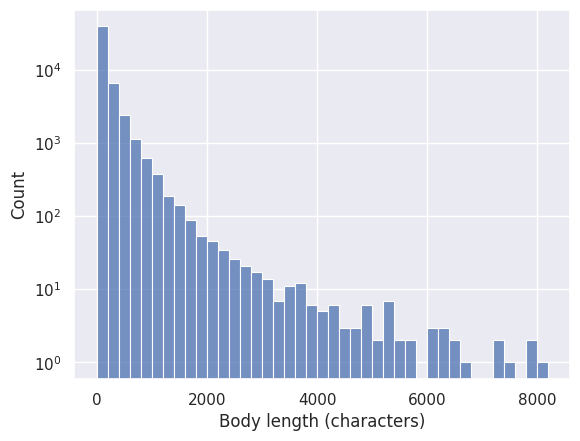

In [32]:
lengths = df["body"].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log")

<Axes: xlabel='time', ylabel='Count'>

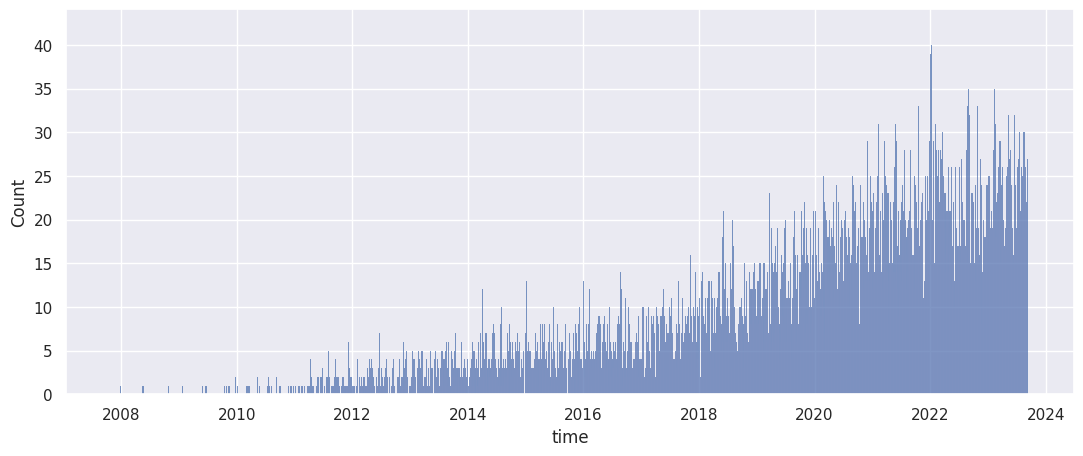

In [17]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
sns.histplot(data=df, x="time", binwidth=timedelta(days=30))

# Distributed Sampling?

In [2]:
class Generator:
    def __init__(
        self,
        seed: int,
        end: int,
        step: int,
        iter_num: int = 0,
        id: Optional[int] = None,
    ):
        """
        # Parameters
        * `seed` - Seed to shuffle starts
        * `end` - Where the generator ends
        * `step` - Step size
        * `iter_num` - How many times we've reached `end` (0 for very start)
        * `id` - The last generated id"""

        self.end = end
        self.step = step

        rand = random.Random(seed)
        self.all_starts = list(range(step))
        rand.shuffle(self.all_starts)

        for _ in range(iter_num):
            self.all_starts.pop()

        if id is not None:
            self.id = id
        else:
            self.id = self.all_starts.pop() - step

    def get_state(self):
        iter_num = self.step - len(self.all_starts)
        return (self.seed, self.end, self.step, iter_num, self.id)

    def __next__(self):
        self.id = self.id + self.step
        if self.id <= self.end:
            return self.id

        self.id = self.all_starts.pop()
        return self.id

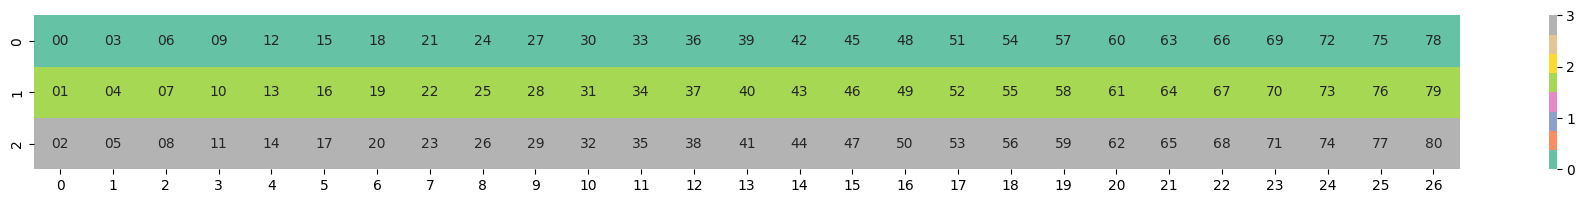

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


num_comps = 3
end = num_comps**4  # 81 IDs in all
gens = [
    Generator(seed=i, end=end // num_comps - 1, step=num_comps * num_comps)
    for i in range(num_comps)
]

mat = [[0 for _ in range(end // num_comps)] for _ in range(num_comps)]
ids = [[j * num_comps + i for j in range(end // num_comps)] for i in range(num_comps)]

fig = plt.figure(figsize=(23, 2))

def init():
    sns.heatmap(
        mat,
        vmin=0,
        vmax=len(gens),
        cbar_kws={"ticks": list(range(len(gens) + 1))},
        cmap=sns.color_palette("Set2"),
        annot=ids,
        fmt="02d",
        # square=True,
    )


def animate(i):
    for i, gen in enumerate(gens):
        id = next(gen)
        assert mat[i][id] == 0
        mat[i][id] = i + 1
    sns.heatmap(mat, cbar=False, cmap=sns.color_palette("Set2"))


anim = animation.FuncAnimation(
    fig, animate, init_func=init, repeat=False, frames=end // num_comps,
)
anim.save("foo.mp4")
plt.show()